# Index-Tracking Portfolio Optimization

Index-Tracking investing is a passive investment strategy that attempts to generate returns similar to a broad market index.

**Full Replication**

A physical index replication where the fund holds the shares of all the assets in the index and needs to replicate as close as possible each asset’s weight in the index. Trading illiquid assets in the index could add to higher costs to the fund, resulting in higher expense ratios and impacting the fund's performance.

**Portfolio Optimization**

The aim is replicate the index using an optimal portfolio selection of the larger assets in the index by reducing Tracking Error.

**Tracking Error**

In the contexts of indices,

Tracking Error = Standard Deviation of (P - I)

The standard deviation of the difference between the returns of a portfolio and the index.


Information Ratio (Similar to Sharpe) = (Portfolio Return - Index Return) / Tracking Error
CFA Institute's Performance Evaluation https://www.cfainstitute.org/-/media/documents/support/programs/investment-foundations/19-performance-evaluation.ashx?la=en&hash=F7FF3085AAFADE241B73403142AAE0BB1250B311

**Russell 1000**
is a stock market index maintained by FTSE Russell that tracks the highest-ranking 1,000 stocks in the entire U.S stock market that we aim to replicate

**Test Period:** 2019-04-01 to 2019-04-30

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Index-Tracking-Portfolio-Optimization" data-toc-modified-id="Index-Tracking-Portfolio-Optimization-0">Index-Tracking Portfolio Optimization</a></span></li><li><span><a href="#1.-Packages" data-toc-modified-id="1.-Packages-1">1. Packages</a></span></li><li><span><a href="#2.-Data-Collection" data-toc-modified-id="2.-Data-Collection-2">2. Data Collection</a></span></li><li><span><a href="#3.-Benchmark-Index-Reconstruction-based-on-Russell-Methodology" data-toc-modified-id="3.-Benchmark-Index-Reconstruction-based-on-Russell-Methodology-3">3. Benchmark Index Reconstruction based on Russell Methodology</a></span></li><li><span><a href="#4.-Allocation-with-Non-negative-Least-Squares-(NNLS)-Optimization" data-toc-modified-id="4.-Allocation-with-Non-negative-Least-Squares-(NNLS)-Optimization-4">4. Allocation with Non-negative Least Squares (NNLS) Optimization</a></span><ul class="toc-item"><li><span><a href="#4.1-Using-data-since-the-latest-reconstitution" data-toc-modified-id="4.1-Using-data-since-the-latest-reconstitution-4.1">4.1 Using data since the latest reconstitution</a></span></li><li><span><a href="#4.2-Using-data-before-the-latest-reconstitution" data-toc-modified-id="4.2-Using-data-before-the-latest-reconstitution-4.2">4.2 Using data before the latest reconstitution</a></span></li><li><span><a href="#4.3-Testing-hypothesis-that-the-error-is-due-to-relying-on-the-wrong-components" data-toc-modified-id="4.3-Testing-hypothesis-that-the-error-is-due-to-relying-on-the-wrong-components-4.3">4.3 Testing hypothesis that the error is due to relying on the wrong components</a></span></li></ul></li><li><span><a href="#5.-Allocation-with-relative-Partial-Correlation" data-toc-modified-id="5.-Allocation-with-relative-Partial-Correlation-5">5. Allocation with relative Partial Correlation</a></span></li><li><span><a href="#6.-Allocation-with-Dynamic-Time-Warping-(DTW)-Optimization" data-toc-modified-id="6.-Allocation-with-Dynamic-Time-Warping-(DTW)-Optimization-6">6. Allocation with Dynamic Time Warping (DTW) Optimization</a></span></li><li><span><a href="#7.-Allocation-with-Non-negative-Matrix-Factorization-(NMF)" data-toc-modified-id="7.-Allocation-with-Non-negative-Matrix-Factorization-(NMF)-7">7. Allocation with Non-negative Matrix Factorization (NMF)</a></span></li><li><span><a href="#8.-Allocation-with-Particle-Swarm-Optimisation-(PSO)" data-toc-modified-id="8.-Allocation-with-Particle-Swarm-Optimisation-(PSO)-8">8. Allocation with Particle Swarm Optimisation (PSO)</a></span></li></ul></div>

# 1. Packages

In [ ]:
# <-- Click In[66] to see code
import math
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import pyswarms as ps
from scipy.optimize import nnls
from datetime import date
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML
from sklearn.decomposition import NMF
from tslearn.metrics import dtw
from pyswarms.utils.search.grid_search import GridSearch
from pyswarms.utils.search.random_search import RandomSearch
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

# 2. Data Collection

According to the FTSE Russell annual reconstitution schedules, there is a 'rank day' where the rankings for the top 1000 companies by market cap are computed at market close. Subsequently, there is a transition period before the reconstitution takes place on the 'effect day' where markets open with the newly reconstituted index. We should be careful to account for this in approximating the index with the top companies because they (or their weights) might change across the years.

https://www.ftserussell.com/press/ftse-russell-announces-schedule-annual-russell-us-index-reconstitution
https://www.ftserussell.com/press/ftse-russell-announces-2018-russell-us-indexes-reconstitution-schedule

I was unable to find free public data of the top 25 constituents of Russell 1000 at every reconstitution. It was unavailable on YahooFinance, my retail broker TDAmeritrade, FTSE's page, Quandl, and google searches on different key words. The following alternatives I've found include:

- Using FTSE's published weights as of 2019-12-31 - goes beyond the test data period and would likely be inaccurate.
https://www.ftse.com/ANALYTICS/FACTSHEETS/HOME/DownloadConstituentsWeights/?indexdetails=US1000


- Using the largest ETF (by AUM) tracking the index to obtain component weights - data as of 2019-12-31. https://www.ishares.com/us/products/239707/ishares-russell-1000-etf/1467271812596.ajax?fileType=csv&fileName=IWB_holdings&dataType=fund


- Chosen option: Using the Top 10 components of the index published by FTSE's reconstitution recap report in 2018 and 2017. While limited to only 10, the allocation is correct at least.
https://content.ftserussell.com/sites/default/files/support_document/2017_russell_reconstitution_recap_final.pdf
https://content.ftserussell.com/sites/default/files/support_document/2018-russell-us-index-reconstitution-recap_0.pdf

**Dates**

In [ ]:
# <--
rank_day17 = "2017-05-12"
effect_day17 = "2017-06-26"
rank_day18 = "2018-05-11"
effect_day18_minus1 = "2018-06-24"
effect_day18 = "2018-06-25"
train_end = "2019-02-28"
val_start = "2019-03-01" # validate on a 1-month-before hold-out set
val_end = "2019-03-31"
test_start = "2019-04-01"
test_end = "2019-04-30"

**Top 10 components and their weights**

Obtained from

https://content.ftserussell.com/sites/default/files/support_document/2017_russell_reconstitution_recap_final.pdf
https://content.ftserussell.com/sites/default/files/support_document/2018-russell-us-index-reconstitution-recap_0.pdf

In [ ]:
# <--
top10of17_cap = {'AAPL':813.9,'GOOG':644.9,'MSFT':527.9,'AMZN':459.5,'FB':435.7,'BRK-B':402.9,'XOM':349.8,'JNJ':333.1,'JPM':308.8,'WFC':265}
top10of18_cap = {'AAPL':926.9,'AMZN':777.8,'GOOG':762.8,'MSFT':750.6,'FB':541.3,'BRK-B':491.8,'JPM':387.7,'XOM':344.1,'JNJ':341.3,'BAC':313.5}

**Calculate no. of shares available**

According to the Russell Index Calculation Methodology, the Total Return index calculation requires knowledge of the dividend ex-dates and dividend/special dividend per share. Since we are limited by data, we will use the Price Return index calculation instead.

https://research.ftserussell.com/products/downloads/Russell_Index_Calculation_Methodology.pdf?_ga=2.110735813.1991880057.1587129456-1914712361.1587129456

Without taking into account corporate action for each stock, I made the assumption that the no. of shares available changes only at the reconstitution dates. The no. of shares will not be exact as the market cap provided by FTSE above is rounded.

In [ ]:
# <--
# Store no. of shares for each component
top10of17_shares = {}
top10of18_shares = {}

components17_query = " ".join(list(top10of17_cap.keys()))
components18_query = " ".join(list(top10of18_cap.keys()))

rank_day17_data = yf.download(tickers = components17_query,
                   start=rank_day17,
                   end=rank_day17,
                   interval="1d",group_by="ticker",auto_adjust=True,prepost=False,threads=True);

rank_day18_data = yf.download(tickers = components18_query,
                   start=rank_day18,
                   end=rank_day18,
                   interval="1d",group_by="ticker",auto_adjust=True,prepost=False,threads=True);

for component in top10of17_cap.keys():
    top10of17_shares[component] = math.ceil(top10of17_cap[component] * 10**9 / rank_day17_data[component]['Close'])

for component in top10of18_cap.keys():
    top10of18_shares[component] = math.ceil(top10of18_cap[component] * 10**9 / rank_day18_data[component]['Close'])
    
print("\nMarket Cap of Top 10 in 2017", top10of17_shares)
print("\nMarket Cap of Top 10 in 2018", top10of18_shares)

**Collect Index and Component Close**

In [ ]:
# <--
# Index
RUI = yf.download(tickers = "^RUI",
                   start=effect_day17,
                   end=test_end,
                   interval="1d",group_by="column",auto_adjust=True,prepost=False,threads=True)
# Components
components17 = yf.download(tickers=components17_query,
                   start=effect_day17,
                   end=effect_day18_minus1,
                   interval="1d",group_by="column",auto_adjust=True,prepost=False,threads=True)['Close']

components18 = yf.download(tickers=components18_query,
                   start=effect_day18,
                   end=test_end,
                   interval="1d",group_by="column",auto_adjust=True,prepost=False,threads=True)['Close']

# 3. Benchmark Index Reconstruction based on Russell Methodology

As mentioned above, we will use the Price Return Index calculation from

https://research.ftserussell.com/products/downloads/Russell_Index_Calculation_Methodology.pdf?_ga=2.110735813.1991880057.1587129456-1914712361.1587129456 page 4

The Russell Index value is obtained by compounding the daily return percentages of the Price Return Index. The starting value of the index is equal to the base and this was set as 100 on 12/31/78. Therefore on our base date: 2017-06-27, we will use the ^RUI's Close = 1341.03 (from Yahoo Finance) as our base value

https://research.ftserussell.com/products/downloads/Russell-US-equity-indexes-IOSCO.pdf?_ga=2.110735813.1991880057.1587129456-1914712361.1587129456 page 34

In [ ]:
# <--
components17.head(3)

**Calculation based on Russell Methodology**

In [ ]:
# <--
market_value17 = pd.DataFrame({'Market Value':np.zeros(len(components17.index))}, index=components17.index)
market_value18 = pd.DataFrame({'Market Value':np.zeros(len(components18.index))}, index=components18.index)
for component in top10of17_cap.keys():
    market_value17['Market Value'] =  market_value17['Market Value'] + components17[component] * top10of17_shares[component]
for component in top10of18_cap.keys():
    market_value18['Market Value'] = market_value18['Market Value'] + components18[component] * top10of18_shares[component]
benchmark = pd.concat([market_value17,market_value18])
benchmark['EMV/BMV'] = benchmark['Market Value'] / benchmark['Market Value'].shift(1)
# not rolling but just use price return = emv/bmv - 1 as the first IV only
current_IV = benchmark['Market Value'].pct_change()[1]
IVs = [np.nan, current_IV]
# updating and adding IVs for each subsequent day
for ratio in benchmark['EMV/BMV'][2:]:
    IVs.append(current_IV*ratio)
    current_IV *= ratio
benchmark['IV'] = IVs 
benchmark['Return'] = benchmark['IV'].pct_change() * 100
benchmark['Daily Compounded Return'] = benchmark['Return'].cumsum()
benchmark['Benchmark Close'] = benchmark['Daily Compounded Return'] + 1341.03
benchmark.head()

**Overall evaluation of benchmark against actual index**

In [ ]:
# <--
benchmark.dropna(inplace=True)
benchmark_close = benchmark['Benchmark Close']
RUI['Actual Close'] = RUI['Close']
index_close = RUI[(benchmark.index[0] <= RUI.index) & (RUI.index <= benchmark.index[-1])]['Actual Close']
closes = pd.concat([index_close,benchmark_close], axis=1)
closes.plot();

**Evaluation of benchmark in test period**

In [ ]:
# <--
test = closes[(closes.index >= "2019-04-01") & (closes.index <= "2019-04-30")]

def evaluate(df,portfolio_col,is_test):
    df2 = pd.DataFrame({
        'Actual Daily Return':df['Actual Close'].pct_change()
    })
    
    index_hpr = (df['Actual Close'][-1] - df['Actual Close'][0]) / df['Actual Close'][0]
    
    if is_test:
        benchmark_hpr = (df['Benchmark Close'][-1] - df['Benchmark Close'][0]) / df['Benchmark Close'][0]
        benchmark_active_return = benchmark_hpr - index_hpr
        benchmark_return = df['Benchmark Close'].pct_change().dropna()
        actual_return = df['Actual Close'].pct_change().dropna()
        benchmark_tracking_error = np.std(benchmark_return - actual_return)
        info_ratio = benchmark_active_return / benchmark_tracking_error
        df2['Benchmark Daily Return'] = df['Benchmark Close'].pct_change()
        print("Benchmark")
        print("*"*30)
        print("Active Return:", round(benchmark_active_return,5))
        print("Tracking Error:", round(benchmark_tracking_error*10000), " bps")
        print("Information Ratio:", round(info_ratio,5))
        print("Price RMSE:", mean_squared_error(df['Benchmark Close'],df['Actual Close'],squared=False))
        df2['Benchmark Daily Return'] = df['Benchmark Close'].pct_change()
        df2.dropna(inplace=True)
        print("Returns RMSE:", mean_squared_error(df2['Benchmark Daily Return'],df2['Actual Daily Return'],squared=False))
    
    if portfolio_col:
        portfolio_hpr = (df[portfolio_col][-1] - df[portfolio_col][0]) / df[portfolio_col][0]
        portfolio_active_return = portfolio_hpr - index_hpr
        
        portfolio_return = df[portfolio_col].pct_change().dropna()
        actual_return = df['Actual Close'].pct_change().dropna()
        portfolio_tracking_error = np.std(portfolio_return - actual_return)
        info_ratio = portfolio_active_return / portfolio_tracking_error
        print("\nCurrent Portfolio")
        print("*"*30)
        print("Active Return:", round(portfolio_active_return,5))
        print("Tracking Error:", round(portfolio_tracking_error*10000), " bps")
        print("Information Ratio:", round(info_ratio,5))
        print("Price RMSE:", mean_squared_error(df[portfolio_col],df['Actual Close'],squared=False))  
        colname = portfolio_col[:-6]+" Daily Return"
        df2[colname] = df[portfolio_col].pct_change()
        df2.dropna(inplace=True)
        print("Returns RMSE:", mean_squared_error(df2[colname],df2['Actual Daily Return'],squared=False))
        
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
    df.plot(ax=axs[0])
    df2.plot(ax=axs[1])

# 4. Allocation with Non-negative Least Squares (NNLS) Optimization

The idea is to fit a linear combination of the current top 10 components against index prices in a constrained linear least squares model for the training period.

The coeffs obtained will then be non-negative. Each coeff is taken over the sum of coeffs as weightings for each component to be taken in the test period.

The sum of weightings will be the amount of leverage that the portfolio requires to replicate the index price.

The method is simple and intuitive, the goal is to find:
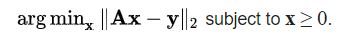

the algorithm used below is obtained from  Lawson, Charles L.; Hanson, Richard J. (1995). Solving Least Squares Problems. SIAM.

## 4.1 Using data since the latest reconstitution 
If we need to generate portfolio weightings for the month of April, we could use several months of training data since the last reconstitution date. However, if we needed to generate portfolio weightings right after the reconstitution, we might have to rely on prices from components which were not previously in the top 10 nor in the index.

**Prices as IVs**

In [ ]:
# <--
# Train Val Test split
df = components18.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

df.head(3)

**Portfolio Allocation**

In [ ]:
# <--
# Obtain coeffs from NNLS training
def get_portfolio_allocation(trainX, trainY):
    result = nnls(trainX, trainY)
    print('NNLS Residual', round(result[1],5))
    
    leverage_factor = sum(result[0])
    weights = result[0] / leverage_factor
    weights = dict(zip(trainX.columns, weights))
    
    s1 = str(round(leverage_factor,5))+"("
    for component in weights.keys():
        s1 += str(round(weights[component],5))+'*'+component+" + "
    s1 = s1[:-3]+")"
    
    print("\nPortfolio Allocation:")
    allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
    allocation.set_index('Component',inplace=True)
    allocation.plot.pie(y='Weight(%)',legend=None)
    allocation.reset_index(inplace=True)
    display(allocation)
    
    print('\nPortfolio Simulated Close = ')
    print(s1)
    print("\nLeverage Factor:", leverage_factor)
    return leverage_factor, weights

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)

**Check for multicollinearity**

In [ ]:
# <--
corr = trainX.corr()
sns.heatmap(corr,cmap="Blues",vmin=0,square=True,linewidths=.5,cbar_kws={"shrink": .5});

The coeffs estimate the effect of a single IV on the DV, holding other IVs constant. Since there is high multicollinearity, it causes imprecise estimates of coeffs, and the val and test coeffs will also be imprecise. This could lead to large errors in extrapolation.

**Validation Results**

In [ ]:
# <--
valY['NNLS Close'] = leverage_factor*valX.dot(list(weights.values()))
evaluate(valY,'NNLS Close',is_test=False)

**Test Results**

In [ ]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'NNLS Close',is_test=True)

RMSE may be a better indicator than the Tracking Error because the benchmark barely changes and thus there is little variance which makes the tracking error naturally low. RMSE is also easier to detect visually.

It seems to match up the prices of the index very well with the simulated index.

## 4.2 Using data before the latest reconstitution
A more realistic scenario would be to train the model on data before the latest reconstitution date so that we could obtain weights to use right after the reconstitution. We might not have the privilege of having training data after the reconstitution.

The training set will then be the entire year's worth of data from the 2017 reconstitution to the 2018 reconstitution.

In [ ]:
# <--
# Train Val Test split
df_before = components17.copy()
df_before.dropna(inplace=True)
df_before['Actual Close'] = RUI['Actual Close']

df_after = components18.copy()
df_after.dropna(inplace=True)
df_after['Actual Close'] = RUI['Actual Close']

train = df_before
val = df_after[(df_after.index >= val_start) & (df_after.index <= val_end)]
test = df_after[(df_after.index >= test_start) & (df_after.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)

**Test Results**

In [ ]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'NNLS Close',is_test=True)

As expected, the Tracking Error & RMSE is much higher since we have relied on prices from components which were not previously in the top 10 nor in the index (WFC was in the top 10 in 2017 but not in 2018).

## 4.3 Testing hypothesis that the error is due to relying on the wrong components
To prove the above hypothesis, I will validate/test on Mar/Apr 2018 rather than train on the 2017 components and validate/test on Mar/Apr 2019 so that it uses the right components for the year.

In [ ]:
# <--
# Train Val Test split
df_before = components17.copy()
df_before.dropna(inplace=True)
df_before['Actual Close'] = RUI['Actual Close']

df_after = components18.copy()
df_after.dropna(inplace=True)
df_after['Actual Close'] = RUI['Actual Close']

train = df_before[(df_before.index < "2018-03-01")]
val = df_before[(df_before.index >= "2018-03-01") & (df_before.index <= "2018-03-31")]
test = df_before[(df_before.index >= "2018-04-01") & (df_before.index <= "2018-04-30")]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)

**Test Results**

In [ ]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'NNLS Close',is_test=True)

The results look a lot better and the Price RMSE reduced significantly. This supports my claim that we should only use the model on the right components for the year. This means we cannot use the model on the earlier months after a reconstitution but should wait until there is sufficient training samples for these components before execution.

# 5. Allocation with relative Partial Correlation
The idea is to allocate more weight to a component if it is more correlated with the index's actual close.

Partial correlation correlates the residuals from 1) least-squares regression of Index on the other IVs & 2) least-squares regression of individual IV on other IVs. This accounts for confounding & 3rd party effects.

**Using correlation without accounting for effects from other variables vs partial correlation**

In [ ]:
# <--
# Train Val Test split
df = components18.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

correls = pd.DataFrame({'Correlation':train.corr()['Actual Close'], 'Partial Correlation':train.pcorr()['Actual Close']})
correls

Ignore negatively correlated components by setting to 0, assuming a Long-only portfolio\
Take each correlation over the sum to get the weightings


**Portfolio Allocation**

In [ ]:
# <--
weights = correls['Partial Correlation'].apply(lambda x:max(0,x))[:-1]
leverage_factor = sum(weights)
weights = (weights / leverage_factor).to_dict()

s1 = str(round(leverage_factor,5))+"("
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]+")"

print("\nPortfolio Allocation:")
allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
allocation.set_index('Component',inplace=True)
allocation.plot.pie(y='Weight(%)',legend=None)
allocation.reset_index(inplace=True)
display(allocation)

print('\nPortfolio Simulated Close = ')
print(s1)
print("\nLeverage Factor:", leverage_factor)

**Validation Results**

In [ ]:
# <--
valY['Partial Correlation Close'] = leverage_factor*valX.dot(list(weights.values()))
evaluate(valY,'Partial Correlation Close',is_test=False)

**Test Results**

In [ ]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['Partial Correlation Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'Partial Correlation Close',is_test=True)

Tracking Error and Returns RMSE are higher than the benchmark. However the Price RMSE is a lot lower.
This is probably due to the oversimplification made by this model in considering effects of each component independently.

# 6. Allocation with Dynamic Time Warping (DTW) Optimization

Pearson correlation is unable to capture shape similarity and will determine that a pair of timeseries are uncorrelated with each other even though they maybe be very similar and simply out of phase. This could be apparent between leading/lagging variables and their counterparts. DTW distance accounts for shape similarity.

The idea is to allocate more weight to a component if it has a relatively shorter DTW distance with the index and thus, a more similar shape.


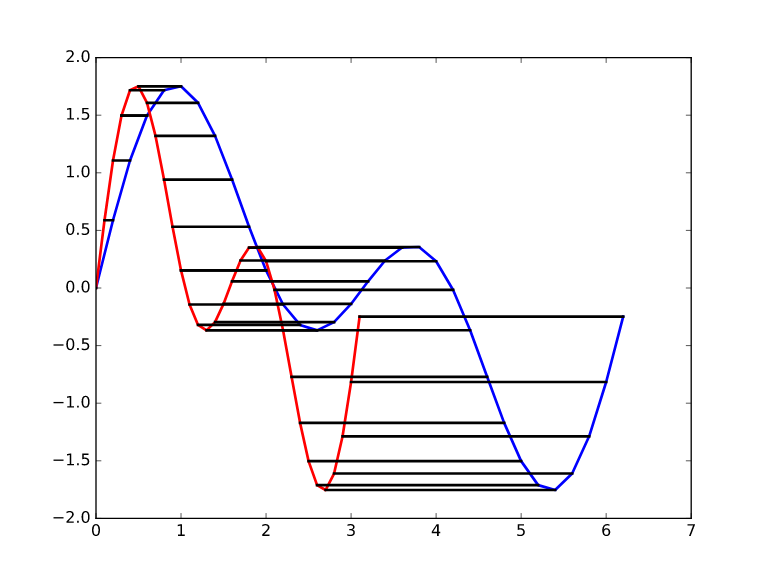

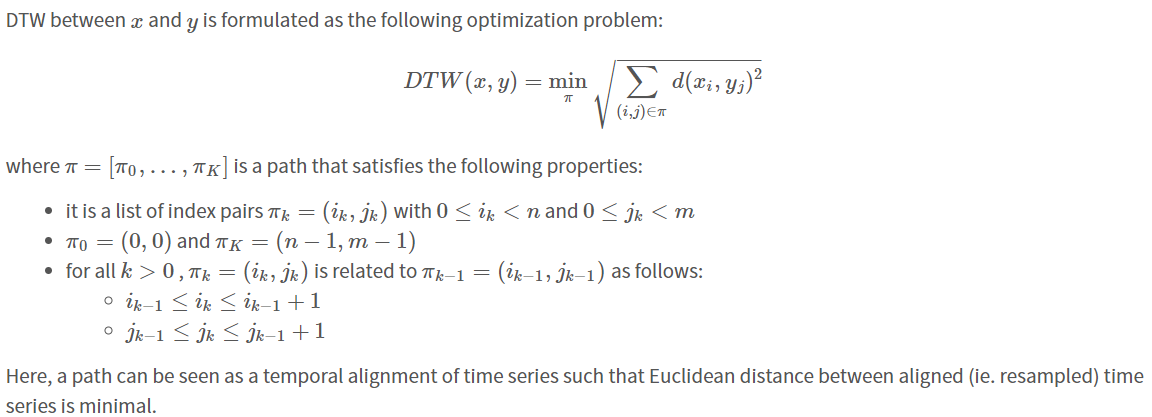

**Dynamic Time Warping Distances**

In [ ]:
# <--
# Train Val Test split
df = components18.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

distances = trainX.apply(lambda x: dtw(x, trainY))
pd.DataFrame({'DTW Distance from Index':distances})

**Portfolio Allocation**

In [ ]:
# <--
distances = 1 / distances
weights = (distances / sum(distances)).to_dict()

s1 = ""
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]

print("\nPortfolio Allocation:")
allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
allocation.set_index('Component',inplace=True)
allocation.plot.pie(y='Weight(%)',legend=None)
allocation.reset_index(inplace=True)
display(allocation)

print('\nPortfolio Simulated Close = ')
print(s1)

**Validation Results**

In [ ]:
# <--
valY['DTW Close'] = valX.dot(list(weights.values()))
evaluate(valY,'DTW Close',is_test=False)

**Test Results**

In [ ]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['DTW Close'] = testX.dot(list(weights.values()))
evaluate(testY,'DTW Close',is_test=True)

Partial Correlation model - Tracking Error: 44  bps, Price RMSE: 86.72, Returns RMSE: 0.004944

The Tracking error, Price RMSE & Returns RMSE performed worse than the Partial Correlation Model. This could mean that the shape similarity might not have been a huge factor in differentiating each component from each other.

# 7. Allocation with Non-negative Matrix Factorization (NMF)
While NNLS is a supervised learning approach, the unsupervised NMF method is able to learn the representation of the data via a single principal component. The principal component will be a linear combination of the assets such that the coeffs will be non-negative due to the constraints in this algo. The algo decomposes the data into two matrices of non-negative elements by optimizing the distance between X and Y=WH. X is represented by linear combinations in W using coeffs in H.
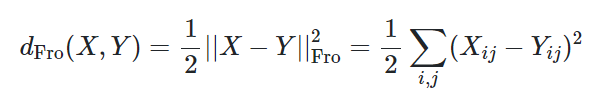
The idea is to find the relative importance of each asset in contributing to the overall variation in the data and use that as our weightings.

In [ ]:
# <--
# Train Val Test split
df = components18.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

**Coeffs in Principal Component**

In [ ]:
# <--
nmf = NMF(n_components=1)
nmf.fit(trainX)
coeffs = nmf.components_.tolist()[0]
leverage_factor = sum(coeffs)
weights = dict(zip(list(trainX.columns), np.divide(coeffs,sum(coeffs))))

s1 = ''
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]

print("\nPortfolio Allocation:")
allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
allocation.set_index('Component',inplace=True)
allocation.plot.pie(y='Weight(%)',legend=None)
allocation.reset_index(inplace=True)
display(allocation)

print('\nPortfolio Simulated Close = ')
print(s1)

**Validation Results**

In [ ]:
# <--
valY['NMF Close'] = valX.dot(list(weights.values()))
evaluate(valY,'NMF Close',is_test=False)

**Test Results**

In [ ]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['NMF Close'] = testX.dot(list(weights.values()))
evaluate(testY,'NMF Close',is_test=True)

The problem with this approach is that the prices cannot be properly replicated as we will not know the leverage factor in an unsupervised learning method, thus the price RMSE is very high.

# 8. Allocation with Particle Swarm Optimisation (PSO)

PSO emulates 'social creatures' that are scattered around the search space and moving to find the optima. Each particle represents a set of portfolio weights which are randomly initialized. Their movements are affected by (1) their individual desire to search and  (2) the collective action of the group or its neighbors.

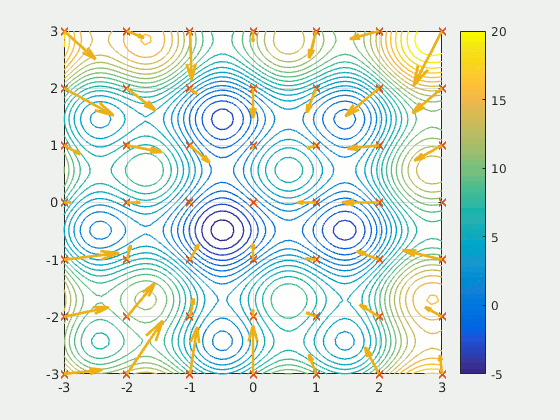

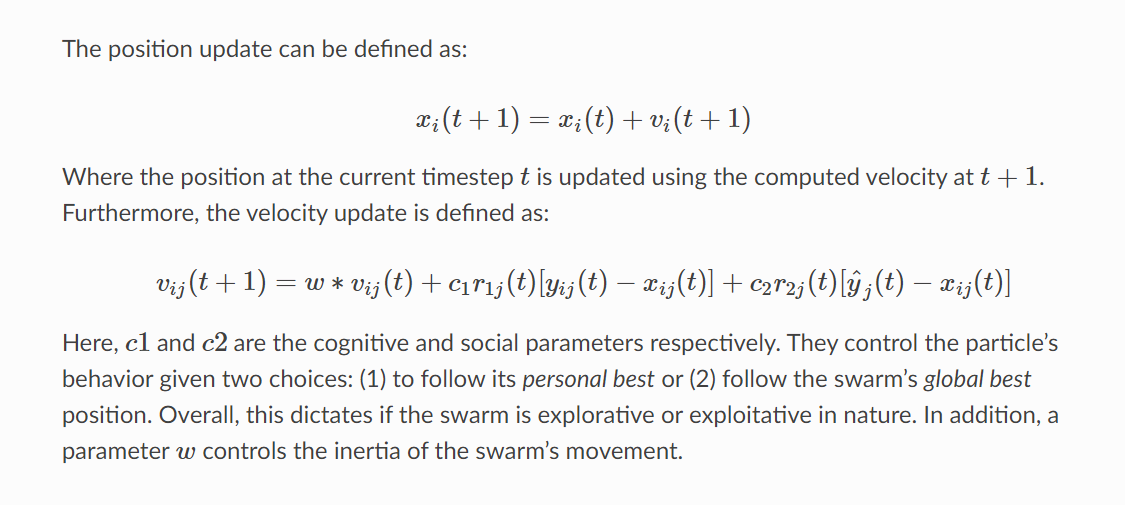

Grid search is performed over c1, c2, w

Bounds = [0,1] since coeffs are non-negative and the value of the component cannot be more than the index



In [ ]:
# <--
# Train Val Test split
df = components18.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

**Grid Search**

In [ ]:
def find_particle_loss(coeffs):
    trainX_returns = trainX.pct_change().dropna()
    trainY_returns = trainY.pct_change().dropna()
    benchmark_tracking_error = np.std(trainX.dot(coeffs) - trainY)
    return benchmark_tracking_error

def swarm(x):
    n_particles = x.shape[0]
    particle_loss = [find_particle_loss(x[i]) for i in range(n_particles)]
    return particle_loss

options = {'c1': [1.5,2.5],
           'c2': [1,2],
           'w': [0.4,0.5]}

feature_count = len(trainX.columns)
min_bound = feature_count*[0]
max_bound = feature_count*[1]

g = GridSearch(GlobalBestPSO,
               objective_func=swarm,
               n_particles=100,
               dimensions=len(trainX.columns),
               options=options,
               bounds=(min_bound,max_bound),
               iters=100)
# Perform optimization, cost=lowest particle_loss among all iterations
best_cost, best_pos = g.search()

**Model Evaluation**

In [ ]:
optimizer = GlobalBestPSO(n_particles=1000,
               dimensions=len(trainX.columns),
               options=best_pos,
               bounds=(min_bound,max_bound))
# Perform optimization, cost=lowest particle_loss among all iterations
cost, pos = optimizer.optimize(swarm,iters=100)

In [ ]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

**Portfolio Allocation**

In [ ]:
# <--
leverage_factor = sum(pos)
weights = pos/leverage_factor
weights = dict(zip(list(trainX.columns), list(weights)))

s1 = str(round(leverage_factor,5))+"("
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]+")"

print("\nPortfolio Allocation:")
allocation = pd.DataFrame({'Component':trainX.columns, 'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
allocation.set_index('Component',inplace=True)
allocation.plot.pie(y='Weight(%)',legend=None)
allocation.reset_index(inplace=True)
display(allocation)

print('\nPortfolio Simulated Close = ')
print(s1)


**Validation Results**

In [ ]:
valY['PSO Close'] = leverage_factor*valX.dot(list(weights.values()))
evaluate(valY,'PSO Close',is_test=False)

**Test Results**

In [ ]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['PSO Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'PSO Close',is_test=True)

NMF (Tracking Error: 56 bps, Price RMSE: 368.7, Returns RMSE: 0.006032)

NNLS (Tracking Error: 43 bps, Price RMSE: 27.37, Returns RMSE: 0.004587)

Tracking Error for the PSO model is the lowest